In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from functools import partial
import visualizations_utils as viz_utils
from iris_plant_visualizer import IrisPlantVisualizer
import ipywidgets as widgets
from IPython.display import display

In [3]:
#pydrake imports
import pydrake
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.geometry import Role, GeometrySet, CollisionFilterDeclaration
from pydrake.solvers import mathematicalprogram as mp
from pydrake.all import RigidTransform, RollPitchYaw, RevoluteJoint, Role

import pydrake.multibody.rational_forward_kinematics as rational_forward_kinematics
from pydrake.all import RationalForwardKinematics
from pydrake.geometry.optimization import (IrisOptionsRationalSpace, 
                                           IrisInRationalConfigurationSpace, 
                                           HPolyhedron, 
                                           Hyperellipsoid,
                                           Iris, IrisOptions)
from pydrake.common import FindResourceOrThrow
#from pydrake.all import ConnectMeshcatVisualizer
from pydrake.all import MeshcatVisualizerCpp, MeshcatVisualizerParams, Role, StartMeshcat,InverseKinematics, RotationMatrix
from meshcat import Visualizer
from visprm import VPRMSeeding, RandSeeding

In [4]:
meshcat1 = StartMeshcat()
meshcat1.Delete()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [5]:

#model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/urdf/iiwa14_polytope_collision.urdf")
model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf")

#model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf")
#model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf")

#box_file = FindResourceOrThrow("drake/sandbox/assets/box.urdf")
box_file_1 = FindResourceOrThrow("drake/C_Iris_Examples/assets/shelves1.sdf")
box_file_2 = FindResourceOrThrow("drake/C_Iris_Examples/assets/shelves2.sdf")
box_file_3 = FindResourceOrThrow("drake/C_Iris_Examples/assets/shelves3.sdf")
box_file_4 = FindResourceOrThrow("drake/C_Iris_Examples/assets/shelves4.sdf")
lid_file = FindResourceOrThrow("drake/C_Iris_Examples/assets/lid.urdf")
ground_file = FindResourceOrThrow("drake/C_Iris_Examples/assets/ground.urdf")

models =[]

builder = DiagramBuilder()


plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat1)
models.append(Parser(plant, scene_graph).AddModelFromFile(model_file))

models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_1))
models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_2))
models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_3))
models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_4))
models.append(Parser(plant, scene_graph).AddModelFromFile(lid_file))
models.append(Parser(plant, scene_graph).AddModelFromFile(ground_file))

sp = 0.4
x_fac = 1.2
locs = [ [0,0,0], 
        [x_fac*sp, 1.4*sp,0.4], [x_fac*sp,-1.4*sp,0.4], [-x_fac*sp,-1.4*sp,0.4], [-x_fac*sp,1.4*sp,0.4], 
        [0.0 ,0 , 0.95], [0.0 ,0 , -0.05]] 
idx = 0
for model in models:
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), RigidTransform(locs[idx]))
    idx +=1
    
    
plant.Finalize()
#visualizer = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, delete_prefix_on_load=False, )

diagram = builder.Build()
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
diagram.Publish(context)
Ratfk = RationalForwardKinematics(plant)

<ipython-input-5-f3400fdd0b71>:21: DrakeDeprecationWarning: MeshcatVisualizerCpp has been renamed to MeshcatVisualizer. The deprecated code will be removed from Drake on or after 2022-11-01.
  visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat1)


In [6]:
sliders = []
for joint_idx in range(1,8):
    sliders.append(
        widgets.FloatSlider(
        min=plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_lower_limit(), 
        max=plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_upper_limit(), 
        value=0, 
        description=f'iiwa_joint_{joint_idx}'
        )
    )

ik = InverseKinematics(plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)

def eval_cons(q, c, tol):
    return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
    
col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)
    
def showres(q):
    for joint_idx in range(1,8):
        plant.GetJointByName(f"iiwa_joint_{joint_idx}").set_angle(plant_context, q[joint_idx-1])
    col = col_func_handle(q)
#     if col:
#         vis["collision"].set_object(
#                 meshcat.geometry.Sphere(0.1), meshcat.geometry.MeshLambertMaterial(color=0xFF0000))
#         vis["collision"].set_transform(
#                 meshcat.transformations.translation_matrix([0, 1.0, 1.0]))
#     else:
#         vis["collision"].set_object(
#                 meshcat.geometry.Sphere(0.1), meshcat.geometry.MeshLambertMaterial(color=0x00FF00))
#         vis["collision"].set_transform(
#                 meshcat.transformations.translation_matrix([0, 1.0, 1.0]))
    diagram.Publish(context)
    print("              ", end = "\r")
    print(col , end = "\r")

    
def set_joint_angles(vals):
    for idx in range(1,8):
        plant.GetJointByName(f"iiwa_joint_{idx}").set_angle(plant_context, vals[idx-1])
    
    
    
q_init = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# q_start = [-1.37, -1.39, -1.57, -1.19, -1.57, 0.00, 0.00]
# q_end = [1.53, -1.19, 1.83, 0.91, -1.27, -0.59, 0.00]
q = q_init.copy()
def handle_slider_change(change, idx):
    q[idx] = change['new']
    #print(q, end="\r")
    showres(q)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

In [7]:
from pydrake.all import Rgba, Sphere

def plot_points(points, 
                size = 0.02, 
                color = Rgba(0.06, 0.0, 0, 1), 
                start_idx = 0, 
                prefix = 'point'):
       
        
        for i in range(points.shape[0]):
            pt = points[i]
            set_joint_angles(pt)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            
            meshcat1.SetObject(f"/iris/points/{prefix}/{i+start_idx}",
                                   Sphere(size),
                                   color)
            
            meshcat1.SetTransform(f"/iris/points/{prefix}/{i+start_idx}",
                                       RigidTransform(RotationMatrix(),
                                                      tf))

In [8]:
for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='iiwa_joint_1', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_2', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_3', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_4', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_5', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_6', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_7', max=3.05433, min=-3.05433)

In [9]:
#problem config
start = np.array([1.13294, 1.3056, 0.03294, -1.2944, -1.76706, 1.5056, 0.0])
target = np.array([-1.86706, 0.5056, -0.26706, -1.0944, -1.36706, 1.1056, 0.04567])

poi = np.array([[1.13294, 1.3056, 0.03294, -1.2944, -1.76706, 1.5056, 0.0],
                [-1.96706,  1.3056 ,  0.03294, -1.2944 , -1.76706,  1.5056 ,
        0.     ],
                [-1.86706, 0.5056, -0.26706, -1.0944, -1.36706, 1.1056, 0.04567],
         [-1.26706,  0.9056 ,  0.13294, -1.0944 , -1.66706, -1.1944 ,
        0.04567],
         [-1.26706,  1.3056 ,  0.13294, -1.0944 , -1.46706, -1.1944 ,
        0.04567],
         [-1.26706,  1.2056 , -0.16706,  0.1056 , -1.46706, -1.1944 ,
        0.04567],
         [ 1.13294,  0.8056 ,  0.03294, -1.2944 , -1.76706,  1.5056 ,
        0.     ],
         [ 1.03294,  0.1056 , -0.06706, -1.5944 , -1.46706,  1.0056 ,
        0.     ],
        [-1.76706,  0.9056 , -0.26706, -1.0944 , -1.36706,  1.1056 ,
        0.04567],
        [ 2.03294,  0.9056 , -0.26706, -1.0944 , -1.16706, -1.2944 ,
        0.04567],
         [ 2.23294,  0.6056 , -0.26706, -1.0944 , -1.46706, -1.2944 ,
        0.04567],
          [ 1.83294,  1.9056 , -0.16706,  0.2056 , -1.36706, -1.1944 ,
        0.04567],])
         # [0.03294, 1.7056, -1.26706, -0.5944, 0.0, 1.2056, -0.05433]



showres(target)
limits_q =[plant.GetPositionLowerLimits(), plant.GetPositionUpperLimits()]
limits_t = [Ratfk.ComputeTValue(l, np.zeros(len(l))) for l in limits_q]
#poi = [start, target]
plot_points(np.array(poi))

In [10]:
q

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Setup SNOPT IRIS

In [11]:
domain = HPolyhedron.MakeBox(limits_t[0], limits_t[1])
snopt_iris_options = IrisOptionsRationalSpace()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 20
snopt_iris_options.configuration_space_margin = 1e-3
snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
snopt_iris_options.q_star = np.zeros(7)
snopt_iris_options.relative_termination_threshold = 0.05



def SNOPT_IRIS(q_seed,  regions, plant, context, snoptiris_options, default_domain):
    #print('snopt iris call')
    snoptiris_options.configuration_obstacles = []
    if regions is not None:
        obstacles = []
        for r in regions:
            offset = 0.25*np.min(1/np.linalg.eig(r.MaximumVolumeInscribedEllipsoid().A())[0])
            rnew = HPolyhedron(r.A(), r.b()-offset)
            obstacles.append(rnew)
        snopt_iris_options.configuration_obstacles = obstacles
    plant.SetPositions(plant.GetMyMutableContextFromRoot(context), q_seed.reshape(-1,1))
    r = IrisInRationalConfigurationSpace(plant, plant.GetMyContextFromRoot(context), snoptiris_options, domain)
    return r

SNOPT_IRIS_Handle = partial(SNOPT_IRIS,
                            plant = plant,
                            context = context,
                            snoptiris_options = snopt_iris_options,
                            default_domain = domain)

# Construct vis checker (here still sample based)

In [12]:
def vis(q1, q2, num_checks, col_func_handle):
    q1flat = q1.reshape(-1)
    q2flat = q2.reshape(-1)
    if np.linalg.norm(q1-q2) < 1e-6:
        return [(1-col_func_handle(q1))>0, None]
    tvec = np.linspace(0,1, num_checks)
    for t in tvec:
        q = q1flat*t + (1-t)*q2flat
        if col_func_handle(q):
            return [False, None]
    else:
        return [True, None]
is_LOS = partial(vis, num_checks = 40, col_func_handle = col_func_handle)

# Run Seeding Setup and Guard Phase

In [13]:
LOAD_CHECKPOINT = False
np.random.seed(11)
vs = VPRMSeeding(poi,
                 alpha = 0.1,
                 limits = limits_q,
                 collision_handle = col_func_handle,
                 is_in_line_of_sight = is_LOS, 
                 iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
                 iris_handle_with_obstacles = SNOPT_IRIS_Handle,
                 point_to_region_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7))
                 )
if not LOAD_CHECKPOINT:
    vs.set_guard_regions()
else:
    import pickle
    path = 'seedingcheckpoints/7DOF_VPRMSeeding_state4.pickle'
    with open(path, 'rb') as f:
        checkpoint = pickle.load(f)
    vs.load_checkpoint(checkpoint)

[19:17:49] [VPRMSeeding] Expecting points of interest in q
[19:17:49] [VPRMSeeding] GuardInsertion attempts M: 44
[19:17:49] [VPRMSeeding] 0.9 probability that unseen region is less than 5.0 "%" of Cfree 


KeyboardInterrupt: 

In [14]:
if not LOAD_CHECKPOINT:
    vs.guard_phase()
    seed_points = vs.seed_points
    regions_A = [r.A() for r in vs.regions]
    regions_b = [r.b() for r in vs.regions]
    sample_set_points = [s[0] for s in vs.samples_outside_regions.values()]
    sample_set_vis_regions = [[vs.regions.index(rs) for rs in s[1]] for s in vs.samples_outside_regions.values()]

    data_checkpoint = {'seedpoints': seed_points, 
                       'regionsA': regions_A,
                       'regionsB': regions_b,
                       'sample_set_points': sample_set_points,
                       'sample_set_vis_regions':sample_set_vis_regions}

    import pickle
    with open("7DOF_VPRMSeeding_state4.pickle", "wb") as f:
        pickle.dump(data_checkpoint,f)
else: 
    print('done')

0
[18:58:03] [VPRMSeeding] New guard placed N =  12
[18:58:05] [VPRMSeeding] Sample set size 0
1
[18:58:05] [VPRMSeeding] New guard placed N =  13
[18:58:13] [VPRMSeeding] Sample set size 0
1
[18:58:13] [VPRMSeeding] New guard placed N =  14
[18:58:18] [VPRMSeeding] Sample set size 0
1
[18:58:18] [VPRMSeeding] New guard placed N =  15
[18:58:30] [VPRMSeeding] Sample set size 0
2
[18:58:30] [VPRMSeeding] New guard placed N =  16
[18:58:32] [VPRMSeeding] Sample set size 1
1
[18:58:32] [VPRMSeeding] New guard placed N =  17
[18:58:34] [VPRMSeeding] Sample set size 1
1
[18:58:34] [VPRMSeeding] New guard placed N =  18
[18:58:34] [VPRMSeeding] Sample set size 1
1
[18:58:34] [VPRMSeeding] New guard placed N =  19
[18:58:47] [VPRMSeeding] Sample set size 1
1
[18:58:47] [VPRMSeeding] New guard placed N =  20
[18:58:49] [VPRMSeeding] Sample set size 1
5
[18:58:49] [VPRMSeeding] New guard placed N =  21
[18:59:19] [VPRMSeeding] Sample set size 5
5
[18:59:19] [VPRMSeeding] New guard placed N =  2

# Plot Results after Guard Phase

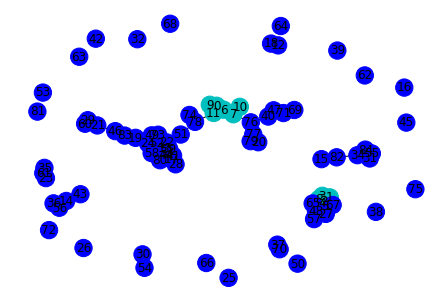

In [16]:
vs.draw_connectivity_graph()
sampleset = [v[0] for v in vs.samples_outside_regions.values()]
plot_points(np.array(vs.seed_points), prefix = 'guard', color = Rgba(0.06, 0.0, 0.8, 1))
plot_points(np.array(sampleset), size=0.01, prefix = 'sampleset', color = Rgba(0.06, 0.8, 0.8, 1))

# Connectivity Phase

In [17]:
vs.connectivity_phase() 

[19:05:21] [VPRMSeeding] Num connected Components Vis: 7
[19:05:45] [VPRMSeeding] New region added [ 0.14485614 -0.64378675 -0.23224519 -2.0487365   0.93840752 -1.49935219
 -1.15192691]
[19:05:45] [VPRMSeeding] Sample set size 563 num keys to del  1
[19:05:46] [VPRMSeeding] Num connected Components Vis: 5
[19:06:24] [VPRMSeeding] New region added [-0.5264382  -0.72069377 -0.1104446  -1.99281799 -0.63715655  0.09968943
  1.14766959]
[19:06:24] [VPRMSeeding] Sample set size 561 num keys to del  2


True

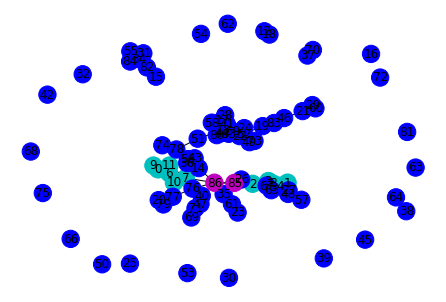

In [18]:
vs.draw_connectivity_graph()

In [18]:
#build configuration graph
class node:
    def __init__(self, loc, regs = None):
        self.loc = loc
        if regs is None:
            self.regions = []
        else:
            self.regions = regs

nodes = [node(Ratfk.ComputeTValue(poi[idx], np.zeros(7)), [vs.regions[idx]]) for idx in range(len(poi))] 
         #node(Ratfk.ComputeTValue(poi[1], np.zeros(7)), [vs.regions[1]])]# + [node(r.MaximumVolumeInscribedEllipsoid().center(), [r]) for r in vs.regions[2:]]



In [19]:
for idx, r in enumerate(vs.regions[:-1]):
    for r2 in vs.regions[idx+1:]:
        if r.IntersectsWith(r2):
            try:
                loc = r.Intersection(r2).MaximumVolumeInscribedEllipsoid().center()
                nodes.append(node(loc, [r, r2]))
            except:
                print('failed ', idx)
            

In [20]:
node_locations = [node.loc for node in nodes]
adjacency_list = []
adjacency_dist = []
for n in nodes:
    edges = []
    edge_dist = []
    for n2 in nodes:
        if nodes.index(n) != nodes.index(n2):
            n_regs = set([str(r) for r in n.regions])
            n2_regs = set([str(r) for r in n2.regions])
            if len(list(n_regs&n2_regs)):
                edges.append(nodes.index(n2))
                edge_dist.append(np.linalg.norm(n.loc-n2.loc))
    adjacency_list.append(edges)
    adjacency_dist.append(edge_dist)

In [23]:
from scipy.sparse.csgraph import dijkstra, csgraph_from_dense
from scipy.sparse import coo_matrix

def build_adjacency_mat(nodes, adjacency_list, adjacency_dist):
        N = len(nodes)
        data = []
        rows = []
        cols = []

        ad_mat = coo_matrix((N, N), np.float32)

        for idx in range(N):
            nei_idx = 0
            for nei in adjacency_list[idx]:
                if not nei == idx:
                    data.append(adjacency_dist[idx][nei_idx])
                    rows.append(idx)
                    cols.append(nei)
                    data.append(adjacency_dist[idx][nei_idx])
                    rows.append(nei)
                    cols.append(idx)
                    # ad_mat[idx, nei] = self.dist_adj[idx][nei_idx]
                    # ad_mat[nei, idx] = self.dist_adj[idx][nei_idx]
                nei_idx += 1

        ad_mat = coo_matrix((data, (rows, cols)), shape=(N, N))
        return ad_mat
ad_mat = build_adjacency_mat(nodes, adjacency_list, adjacency_dist)

In [24]:
#ad_mat = self.build_adjacency_mat()
dist, pred = dijkstra(ad_mat, directed=False, indices=0, return_predecessors=True)
print(f'{len(np.argwhere(pred == -9999))} disconnected nodes'), #np.argwhere(pred == -9999))
pred[pred == -9999] = -100000000

sp_list = []
sp_length = dist[1]
current_idx = 1
sp_list.append(current_idx)
while not current_idx == ad_mat.shape[0] - 2:
    current_idx = pred[current_idx]
    sp_list.append(current_idx)
    if current_idx==0: break
print(sp_list)
waypoints = [nodes[idx].loc for idx in sp_list]

8 disconnected nodes
[1, 16, 19, 23, 38, 36, 40, 13, 0]


In [25]:
def dijkstra_in_configspace(src, target):
    dist, pred = dijkstra(ad_mat, directed=False, indices=src, return_predecessors=True)
    #print(f'{len(np.argwhere(pred == -9999))} disconnected nodes'), #np.argwhere(pred == -9999))
    pred[pred == -9999] = -100000000

    sp_list = []
    sp_length = dist[1]
    current_idx = target
    sp_list.append(current_idx)
    while not current_idx == ad_mat.shape[0] - 2:
        current_idx = pred[current_idx]
        sp_list.append(current_idx)
        if current_idx==src: break
    #print(sp_list)
    return [nodes[idx].loc for idx in sp_list]

#dijkstra_in_configspace(0,5)

In [26]:
def densify_waypoints(waypoints):
    densify = 200
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints[:-1])):
        a = waypoints[idx]
        b = waypoints[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            ta = a*tval + b*(1-tval)
            qa = Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            set_joint_angles(qa)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints[idx]*tval + waypoints[idx+1]*(1-tval))
    return dense_waypoints
        

In [27]:
def plot_endeff_traj(dense_waypoints):
    color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, ta in enumerate(dense_waypoints):
        qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        set_joint_angles(qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        meshcat1.SetObject(f"/iris/points/traj/{i+start_idx}"                    print('here')
,
                               Sphere(0.005),
                               color)

        meshcat1.SetTransform(f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [28]:
for idx, r in enumerate(vs.regions[:-1]):
    for r2 in vs.regions[idx+1:]:
        if r.IntersectsWith(r2):
            try:
                loc = r.Intersection(r2).MaximumVolumeInscribedEllipsoid().center()
                nodes.append(node(loc, [r, r2]))
            except:
                print('failed ', idx)
            for idx, r in enumerate(vs.regions[:-1]):
    for r2 in vs.regions[idx+1:]:
        if r.IntersectsWith(r2):
            try:
                loc = r.Intersection(r2).MaximumVolumeInscribedEllipsoid().center()
                nodes.append(node(loc, [r, r2]))
            except:
                print('failed ', idx)
            import time
#poi_idx = np.arange(len(poi))
start = np.random.choice(len(poi),1)[0]
# start = 8 #np.random.choice(len(poi),1)[0]
# nxt = 10
# wp = dijkstra_in_configspace(start, nxt)
# dense_waypoints = densify_waypoints(wp)
# plot_endeff_traj(dense_waypoints)


# for _ in range(80):
#     while True:
#         nxt = np.random.choice(len(poi),1)[0]
#         if nxt != start:
#             break
#     wp = dijkstra_in_configspace(nxt, start)
#     dense_waypoints = densify_waypoints(wp)
#     plot_endeff_traj(dense_waypoints)
#     for ta in dense_waypoints:
#         qa = Ratfk.ComputeQValue(ta, np.zeros(7))
#         showres(qa)
#         time.sleep(0.007)
#     start = nxt
#     #time.sleep(0.1)
#     meshcat1.Delete("/iris/points/traj/")

In [13]:
from visprm import RandSeeding
rs = RandSeeding(poi,
              alpha = 0.1,
              limits = limits_q,
              collision_handle = col_func_handle,
              iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
              iris_handle_with_obstacles = SNOPT_IRIS_Handle,def dijkstra_in_configspace(src, target):
    dist, pred = dijkstra(ad_mat, directed=False, indices=src, return_predecessors=True)
    #print(f'{len(np.argwhere(pred == -9999))} disconnected nodes'), #np.argwhere(pred == -9999))
    pred[pred == -9999] = -100000000

    sp_list = []
    sp_length = dist[1]
    current_idx = target
    sp_list.append(current_idx)
    while not current_idx == ad_mat.shape[0] - 2:
        current_idx = pred[current_idx]
        sp_list.append(current_idx)
        if current_idx==src: break
    #print(sp_list)
    return [nodes[idx].loc for idx in sp_list]
              point_to_region_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7))
                 )
rs.set_init_regions()

[19:30:19] [RandSeeding] Expecting points of interest in q
[19:30:19] [RandSeeding] GuardInsertion attempts M: 44
[19:30:19] [RandSeeding] 0.9 probability that unseen region is less than 5.0 "%" of Cfree 


In [14]:
rs.sample_regions_phase()

[19:30:48] [RandSeeding] New Region placed N =  12 , it =  0
[19:30:54] [RandSeeding] New Region placed N =  13 , it =  0
[19:30:58] [RandSeeding] New Region placed N =  14 , it =  0
[19:31:01] [RandSeeding] New Region placed N =  15 , it =  0
[19:31:07] [RandSeeding] New Region placed N =  16 , it =  0
[19:31:20] [RandSeeding] New Region placed N =  17 , it =  0
[19:31:32] [RandSeeding] New Region placed N =  18 , it =  0
[19:31:53] [RandSeeding] New Region placed N =  19 , it =  0
[19:31:59] [RandSeeding] New Region placed N =  20 , it =  0
[19:32:03] [RandSeeding] New Region placed N =  21 , it =  0
[19:32:21] [RandSeeding] New Region placed N =  22 , it =  0
[19:32:48] [RandSeeding] New Region placed N =  23 , it =  0
[19:32:53] [RandSeeding] New Region placed N =  24 , it =  0
[19:32:56] [RandSeeding] New Region placed N =  25 , it =  0
[19:33:13] [RandSeeding] New Region placed N =  26 , it =  0
[19:33:27] [RandSeeding] New Region placed N =  27 , it =  0
[19:33:42] [RandSeeding]

True

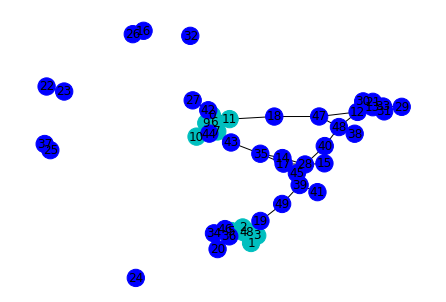

In [15]:
rs.draw_connectivity_graph()

In [32]:
from scipy.sparse.csgraph import dijkstra, csgraph_from_dense
from scipy.sparse import coo_matrix
#build configuration graph
class node:
    def __init__(self, loc, regs = None):
        self.loc = loc
        if regs is None:
            self.regions = []
        else:
            self.regions = regs

nodes = [node(Ratfk.ComputeTValue(poi[idx], np.zeros(7)), [rs.regions[idx]]) for idx in range(len(poi))] 
         #node(Ratfk.ComputeTValue(poi[1], np.zeros(7)), [vs.regions[1]])]# + [node(r.MaximumVolumeInscribedEllipsoid().center(), [r]) for r in vs.regions[2:]]
for idx, r in enumerate(rs.regions[:-1]):
    for r2 in rs.regions[idx+1:]:
        if r.IntersectsWith(r2):
            try:
                loc = r.Intersection(r2).MaximumVolumeInscribedEllipsoid().center()
                nodes.append(node(loc, [r, r2]))
            except:
                print('failed ', idx)
                
node_locations = [node.loc for node in nodes]
adjacency_list = []
adjacency_dist = []
for n in nodes:
    edges = []
    edge_dist = []
    for n2 in nodes:
        if nodes.index(n) != nodes.index(n2):
            n_regs = set([str(r) for r in n.regions])
            n2_regs = set([str(r) for r in n2.regions])
            if len(list(n_regs&n2_regs)):
                edges.append(nodes.index(n2))
                edge_dist.append(np.linalg.norm(n.loc-n2.loc))
    adjacency_list.append(edges)
    adjacency_dist.append(edge_dist)  


In [33]:
def build_adjacency_mat(nodes, adjacency_list, adjacency_dist):
        N = len(nodes)
        data = []
        rows = []
        cols = []

        ad_mat = coo_matrix((N, N), np.float32)

        for idx in range(N):
            nei_idx = 0
            for nei in adjacency_list[idx]:
                if not nei == idx:
                    data.append(adjacency_dist[idx][nei_idx])
                    rows.append(idx)
                    cols.append(nei)
                    data.append(adjacency_dist[idx][nei_idx])
                    rows.append(nei)
                    cols.append(idx)
                    # ad_mat[idx, nei] = self.dist_adj[idx][nei_idx]
                    # ad_mat[nei, idx] = self.dist_adj[idx][nei_idx]
                nei_idx += 1

        ad_mat = coo_matrix((data, (rows, cols)), shape=(N, N))
        return ad_mat
ad_mat = build_adjacency_mat(nodes, adjacency_list, adjacency_dist)

In [34]:
def dijkstra_in_configspace(src, target):
    dist, pred = dijkstra(ad_mat, directed=False, indices=src, return_predecessors=True)
    #print(f'{len(np.argwhere(pred == -9999))} disconnected nodes'), #np.argwhere(pred == -9999))
    pred[pred == -9999] = -100000000

    sp_list = []
    sp_length = dist[1]
    current_idx = target
    sp_list.append(current_idx)
    while not current_idx == ad_mat.shape[0] - 2:
        current_idx = pred[current_idx]
        sp_list.append(current_idx)
        if current_idx==src: break
    #print(sp_list)
    return [nodes[idx].loc for idx in sp_list]

In [35]:
def densify_waypoints(waypoints):
    densify = 200
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints[:-1])):
        a = waypoints[idx]
        b = waypoints[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            ta = a*tval + b*(1-tval)
            qa = Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            set_joint_angles(qa)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints[idx]*tval + waypoints[idx+1]*(1-tval))
    return dense_waypoints

In [39]:
def plot_endeff_traj(dense_waypoints):
    color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, ta in enumerate(dense_waypoints):
        qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        set_joint_angles(qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        meshcat1.SetObject(f"/iris/points/randtraj/{i+start_idx}",
                               Sphere(0.005),
                               color)

        meshcat1.SetTransform(f"/iris/points/randtraj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [ ]:
start = 8 #np.random.choice(len(poi),1)[0]
nxt = 10
wp = dijkstra_in_configspace(start, nxt)
dense_waypoints = densify_waypoints(wp)
plot_endeff_traj(dense_waypoints)

import time

for _ in range(80):
    while True:
        nxt = np.random.choice(len(poi),1)[0]
        if nxt != start:
            break
    wp = dijkstra_in_configspace(nxt, start)
    dense_waypoints = densify_waypoints(wp)
    plot_endeff_traj(dense_waypoints)
    for ta in dense_waypoints:
        qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        showres(qa)
        time.sleep(0.007)
    start = nxt
    #time.sleep(0.1)
    meshcat1.Delete("/iris/points/randtraj/")

In [132]:
for ta in dense_waypoints:
    print(ta)

[-1.33334128  0.55627447  0.23377853 -0.76090425 -0.99057595  0.42082855
  1.10663027]
[-1.30322327  0.55744077  0.23200154 -0.74665967 -0.99641489  0.40637714
  1.09713411]
[-1.27310526  0.55860708  0.23022455 -0.73241508 -1.00225383  0.39192574
  1.08763796]
[-1.24298726  0.55977338  0.22844756 -0.71817049 -1.00809276  0.37747434
  1.0781418 ]
[-1.21286925  0.56093969  0.22667057 -0.70392591 -1.0139317   0.36302293
  1.06864564]
[-1.18275125  0.56210599  0.22489358 -0.68968132 -1.01977063  0.34857153
  1.05914949]
[-1.15263324  0.5632723   0.22311659 -0.67543673 -1.02560957  0.33412013
  1.04965333]
[-1.12251523  0.5644386   0.2213396  -0.66119215 -1.03144851  0.31966872
  1.04015717]
[-1.09239723  0.5656049   0.21956261 -0.64694756 -1.03728744  0.30521732
  1.03066102]
[-1.06227922  0.56677121  0.21778562 -0.63270297 -1.04312638  0.29076592
  1.02116486]
[-1.03216122  0.56793751  0.21600863 -0.61845838 -1.04896531  0.27631451
  1.0116687 ]
[-1.00204321  0.56910382  0.21423164 -0.604

In [165]:
hs = []

for r in vs.regions:
    hs.append(r.A().shape[0])
np.mean(hs)

71.60919540229885

In [107]:
dist, pred = dijkstra(ad_mat, directed=False, indices=10, return_predecessors=True)
print(f'{np.argwhere(dist == np.inf)} disconnected nodes'), #np.argwhere(pred == -9999))

[[32]
 [45]
 [64]
 [69]
 [70]
 [71]
 [74]] disconnected nodes


(None,)

In [105]:
dist

array([ 29.94903904,   6.84408582,  28.14556355,  25.74365554,
        26.91696334,   5.11944492,   4.05410702,   6.09102121,
         5.27431335,   2.54056624,   0.        ,   8.12657567,
         7.73436503,  10.21819863,   6.6985045 ,   4.85028035,
         9.94016202,   4.64799687,  14.26327589,   8.95062303,
         3.51636938,  11.29602561,   4.79078662,  23.69303501,
        25.22362929,  23.40115606,  23.21897144,  22.44986197,
        19.68708906,   2.45628974,  25.10766265,  28.52925012,
                inf,  70.46954116,  81.7158397 ,  60.00518463,
       103.64636859,  52.48091945,  75.89499381,  78.39243952,
        80.94988483,  53.90720828,  43.9084998 ,  49.69789446,
        26.93013639,          inf,  75.40405792,  73.44345549,
       106.98671996, 107.67152555,  93.85786938, 108.1335536 ,
        38.81935516, 124.28556881, 110.55226726, 124.9518669 ,
        84.5550137 ,  81.93976515,  66.87657871,  90.75496007,
        10.37945091,  17.39206999,  69.59489141, 124.90

In [53]:
import networkx as nx
c = []
for comp in nx.connected_components(vs.connectivity_graph):
    c.append(list(comp))

In [27]:
len(vs.regions)

83

In [57]:
locs_connected_comps = [Ratfk.ComputeQValue(vs.regions[i].MaximumVolumeInscribedEllipsoid().center(), np.zeros(7)) for i in c[0]]

In [59]:
color = Rgba(0,0,1,1.0)
for i, qa in enumerate(locs_connected_comps):
    #showres(qa)
    #time.sleep(0.1)            
    set_joint_angles(qa)
    tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

    meshcat1.SetObject(f"/iris/points/reg_center_conn_comp/{i+start_idx}",
                           Sphere(0.03),
                           color)

    meshcat1.SetTransform(f"/iris/points/reg_center_conn_comp/{i+start_idx}",
                               RigidTransform(RotationMatrix(),
                                              tf))

In [71]:
from rrt import RRT
RRT = RRT(start = start,
              goal = target,
              limits = limits_q,
              col_func_handle=col_func_handle,
              max_extend_length=0.1,
              extend_steps=0.002,
              init_goal_sample_rate=0.1,
              goal_sample_rate_scaler=0.9,
              verbose = True, 
              plotcallback = None,
              sample_collision_free= False)

success, path = RRT.run(100000)

0
it: 0 distance to target:  3.199 goalsample prob:  0.100
it: 1 distance to target:  3.167 goalsample prob:  0.100
it: 2 distance to target:  3.153 goalsample prob:  0.100
it: 5 distance to target:  3.134 goalsample prob:  0.100
it: 50 distance to target:  3.115 goalsample prob:  0.100
it: 53 distance to target:  3.108 goalsample prob:  0.100
it: 134 distance to target:  3.105 goalsample prob:  0.100
it: 138 distance to target:  3.103 goalsample prob:  0.100
it: 140 distance to target:  3.091 goalsample prob:  0.100
it: 143 distance to target:  3.090 goalsample prob:  0.100
it: 329 distance to target:  3.076 goalsample prob:  0.100
it: 362 distance to target:  3.075 goalsample prob:  0.100
it: 517 distance to target:  3.068 goalsample prob:  0.100
it: 531 distance to target:  3.064 goalsample prob:  0.100
it: 741 distance to target:  3.026 goalsample prob:  0.100
it: 880 distance to target:  3.025 goalsample prob:  0.100
1000
2000
it: 2944 distance to target:  3.000 goalsample prob:  